# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = (7, 7)

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [2]:
# Читаем файл geo.xlsx
data = pd.read_excel('geo.xlsx')

In [3]:
# Удаляем лишние столбцы
data = data[['x', 'y', 'comment_class']]
data.head(5)

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [4]:
# Проверяем качество данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   x              108806 non-null  float64
 1   y              108806 non-null  float64
 2   comment_class  108806 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 MB


In [5]:
data['comment_class'].value_counts()

-1    95147
 1    13659
Name: comment_class, dtype: int64

In [6]:
def get_clasters(data, n_clusters, clasters_range):
  plt.scatter(x=data['x'], y=data['y'], color='green')
  plt.title('Расположение голосов до класстеризации')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

  # Делаем поиск кластеров с помощью KMeans
  # Сначала определяем оптимальное количество кластеров
  clasters_inertia = []
  for _ in clasters_range:
      clf_kmeans = KMeans(n_clusters=_)
      clf_kmeans.fit_predict(data.drop('comment_class', axis=1))
      clasters_inertia.append(clf_kmeans.inertia_)
  plt.plot(clasters_range, clasters_inertia)
  plt.title('Сумма квадратов до центроидов кластеров')
  plt.xlabel('Количество кластеров')
  plt.ylabel('Сумма квадратов')
  plt.show()

  # Или подбираем с помощью формулы (из тетрадки)
  diff = np.diff(clasters_inertia)
  k_opt = clasters_range[np.argmin(diff[1:] / diff[:-1])+1]
  print(f'Оптимальное количество кластеров - {k_opt}')

  # В случае k_opt класторов
  plt.scatter(x=data['x'], y=data['y'], c=KMeans(n_clusters=k_opt).fit_predict(data.drop('comment_class', axis=1)))
  plt.title(f'Количество кластеров с k_opt - {k_opt}')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

  # В случае 4-х кластеров
  plt.scatter(x=data['x'], y=data['y'], c=KMeans(n_clusters=n_clusters).fit_predict(data.drop('comment_class', axis=1)))
  plt.title(f'Количество кластеров - {n_clusters}')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

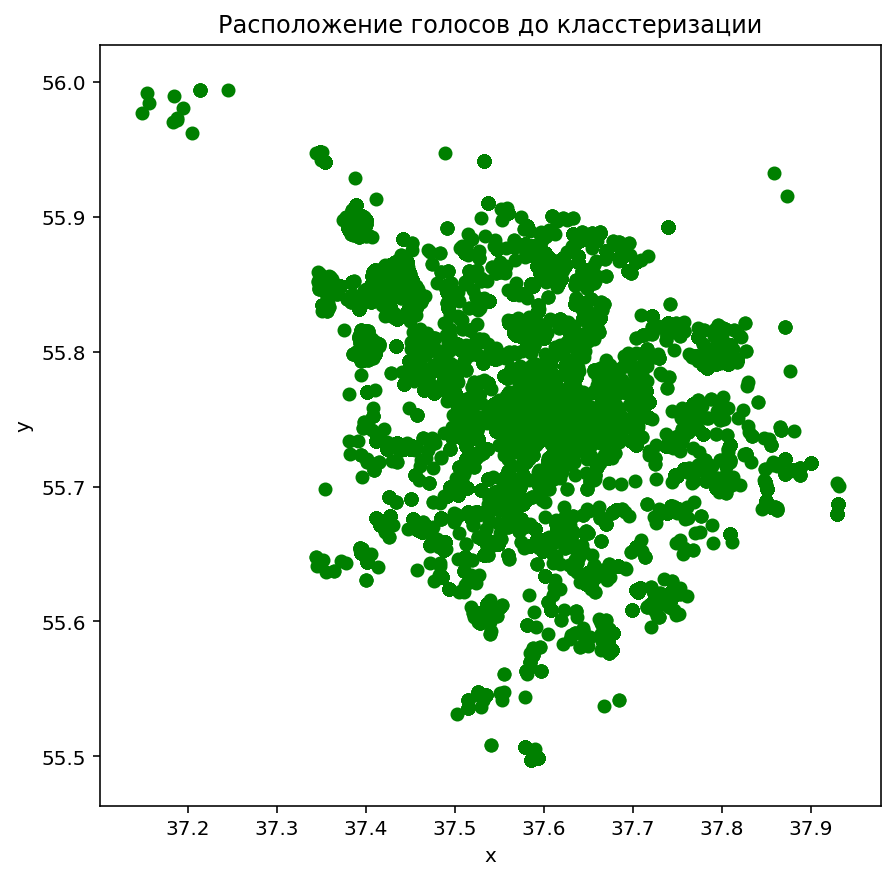

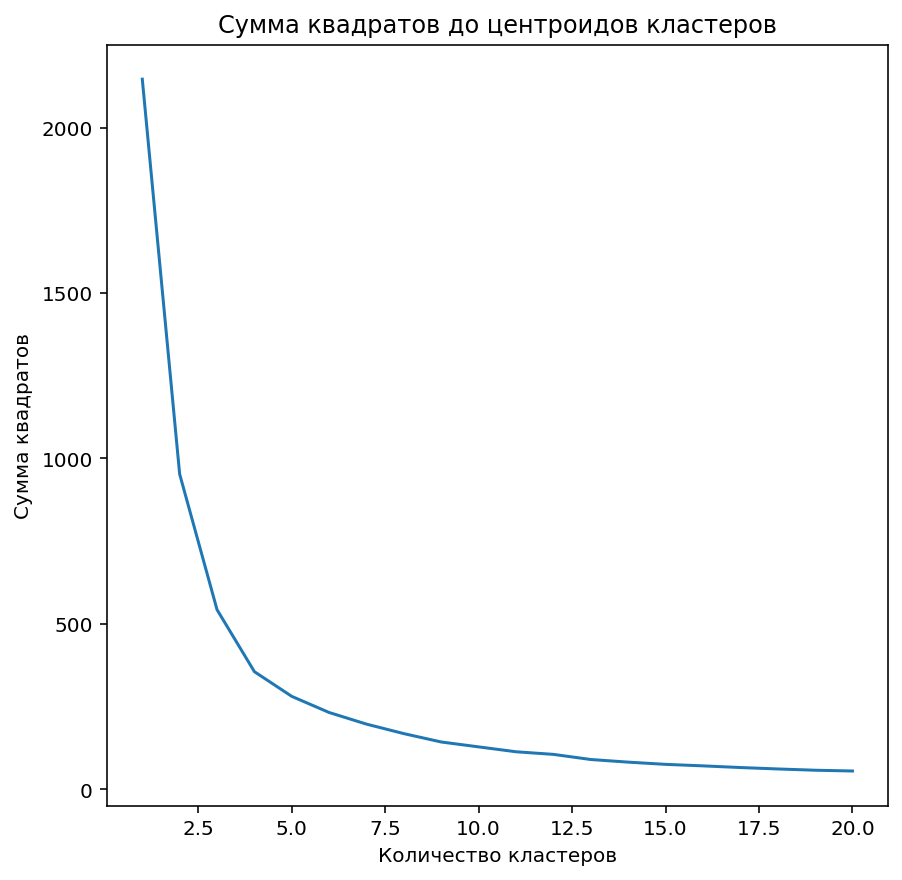

Оптимальное количество кластеров - 2


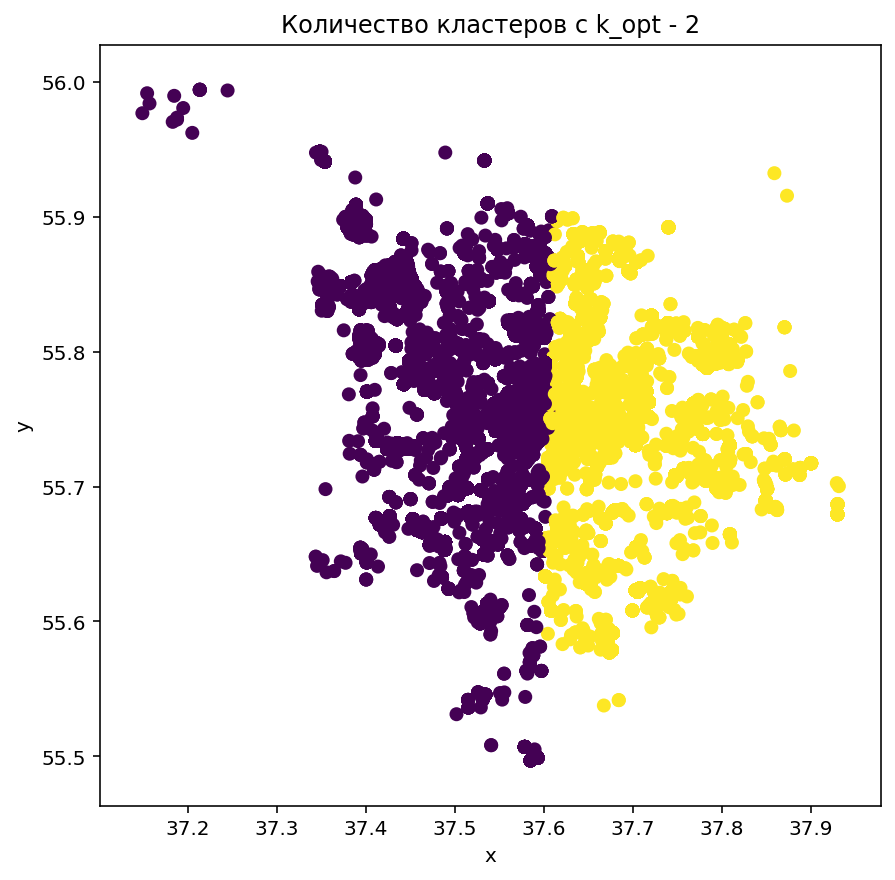

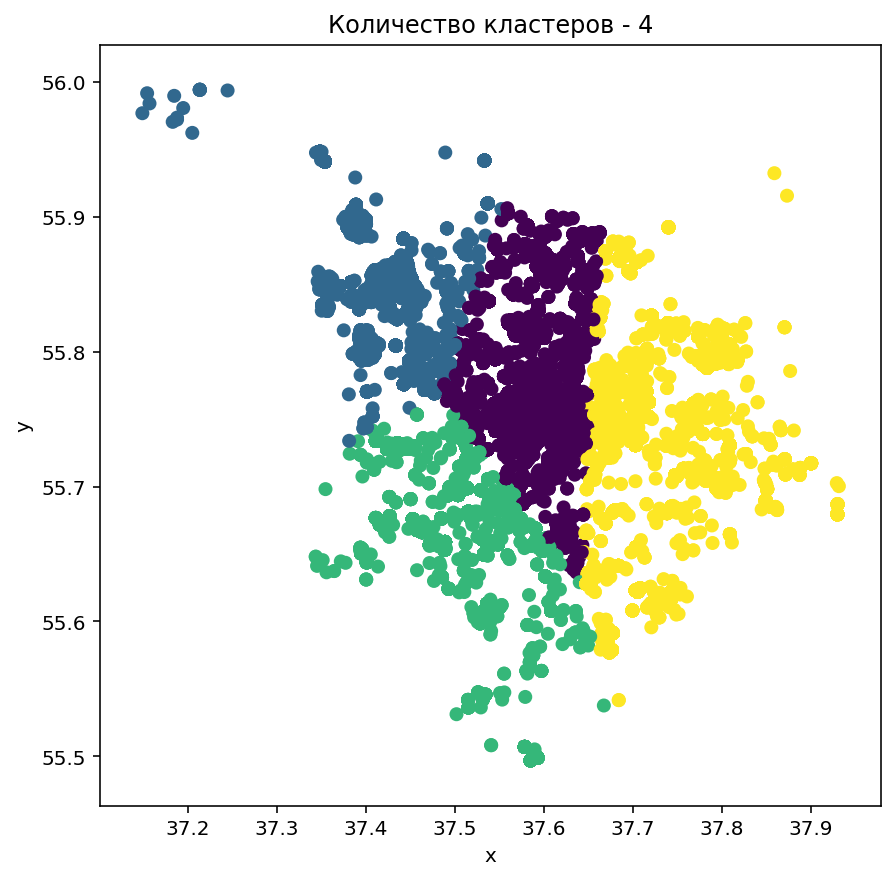

In [7]:
# Визуально делим город на районы без относительно голосов (проводим кластеризацию и выводим картинку)
get_clasters(data=data, n_clusters=4, clasters_range=range(1, 21))

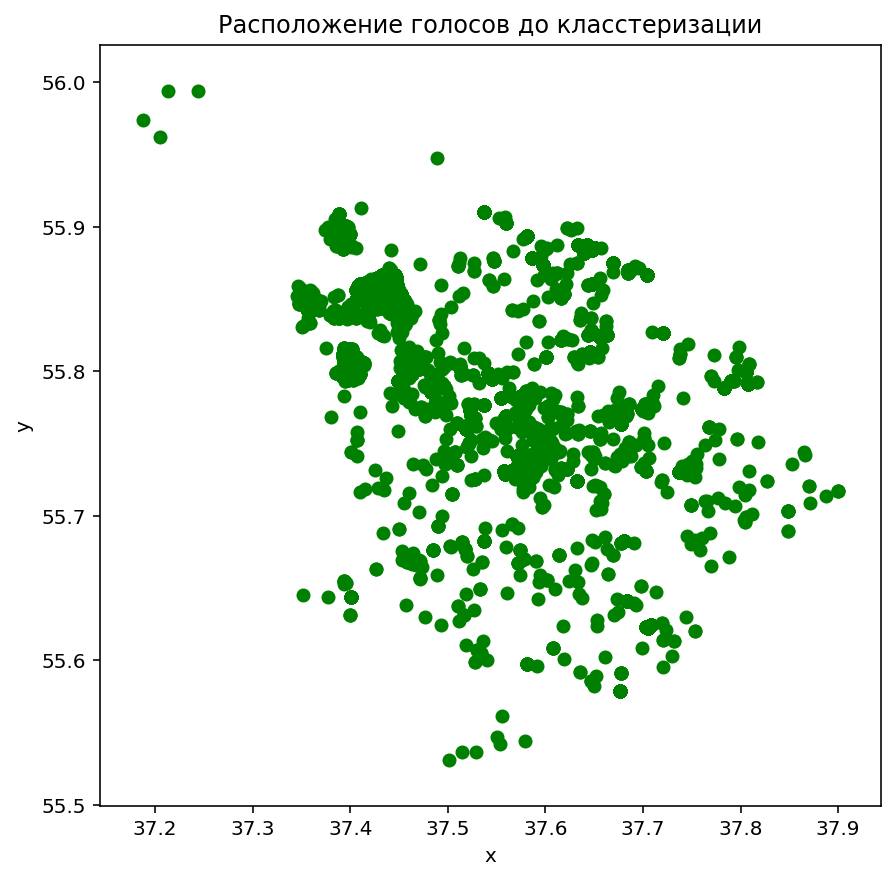

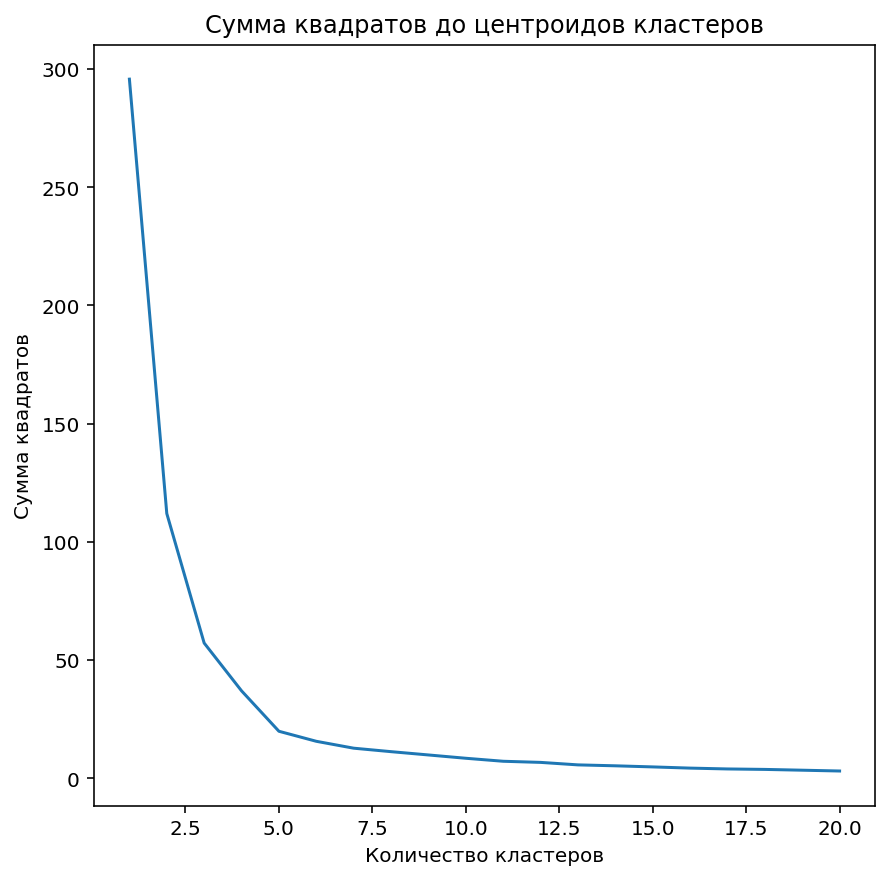

Оптимальное количество кластеров - 5


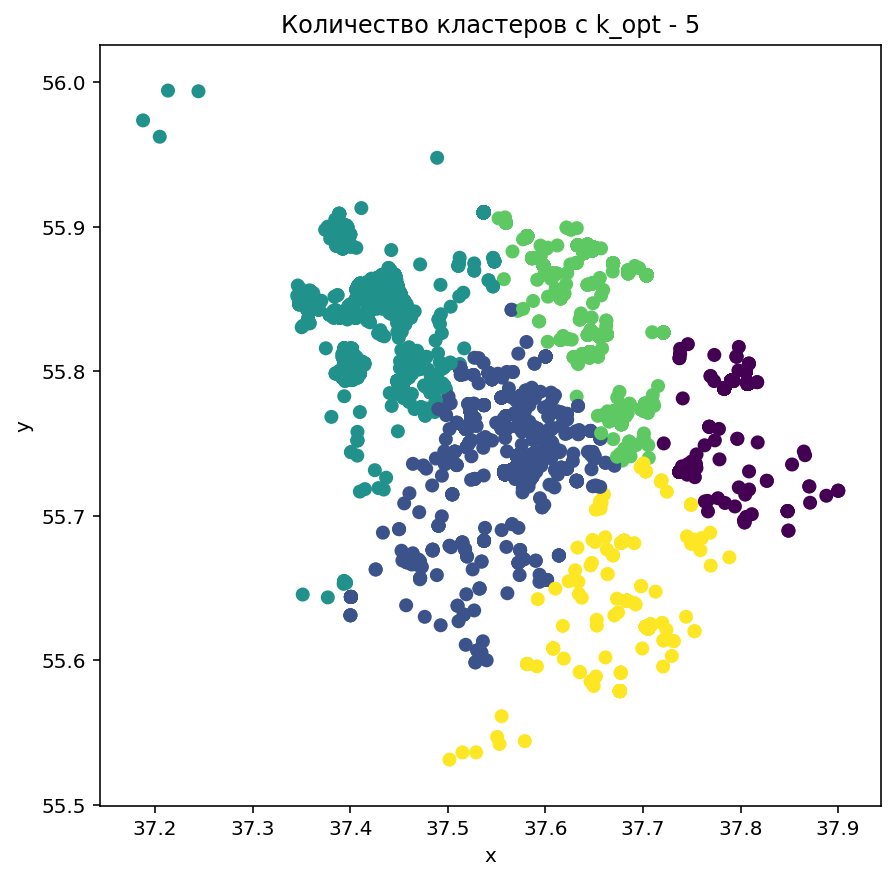

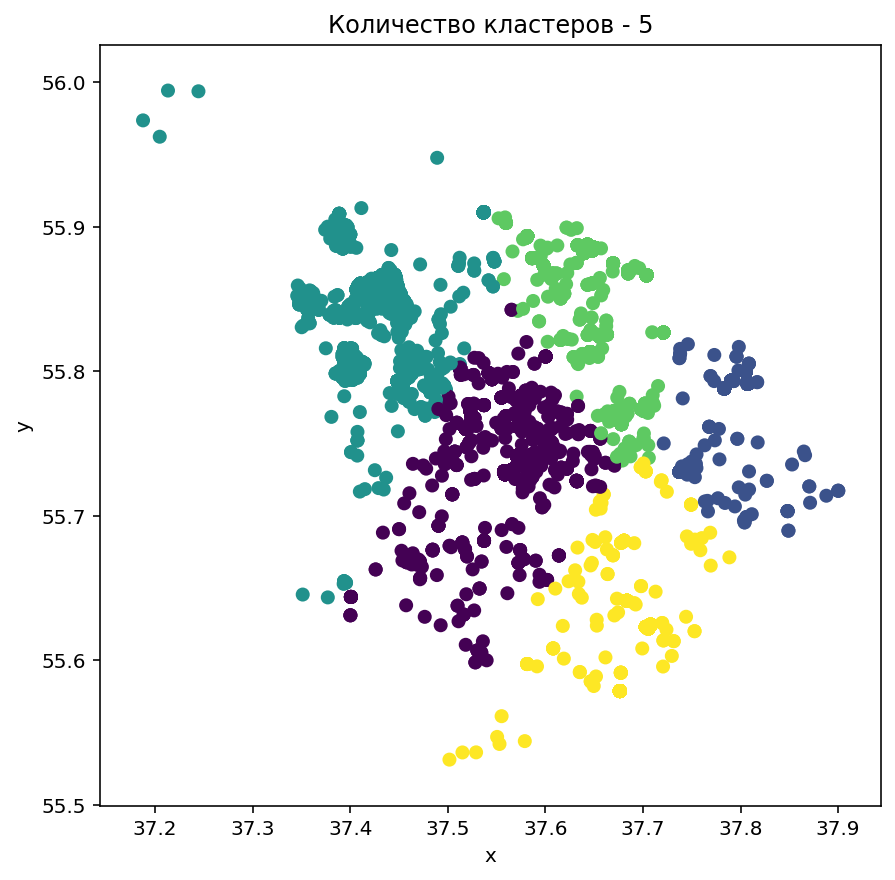

In [8]:
# Аналогично исследуем скопления голосов за и против отдельно
# С положительным голосом
get_clasters(data=data[data['comment_class'] == 1], n_clusters=5, clasters_range=range(1, 21))

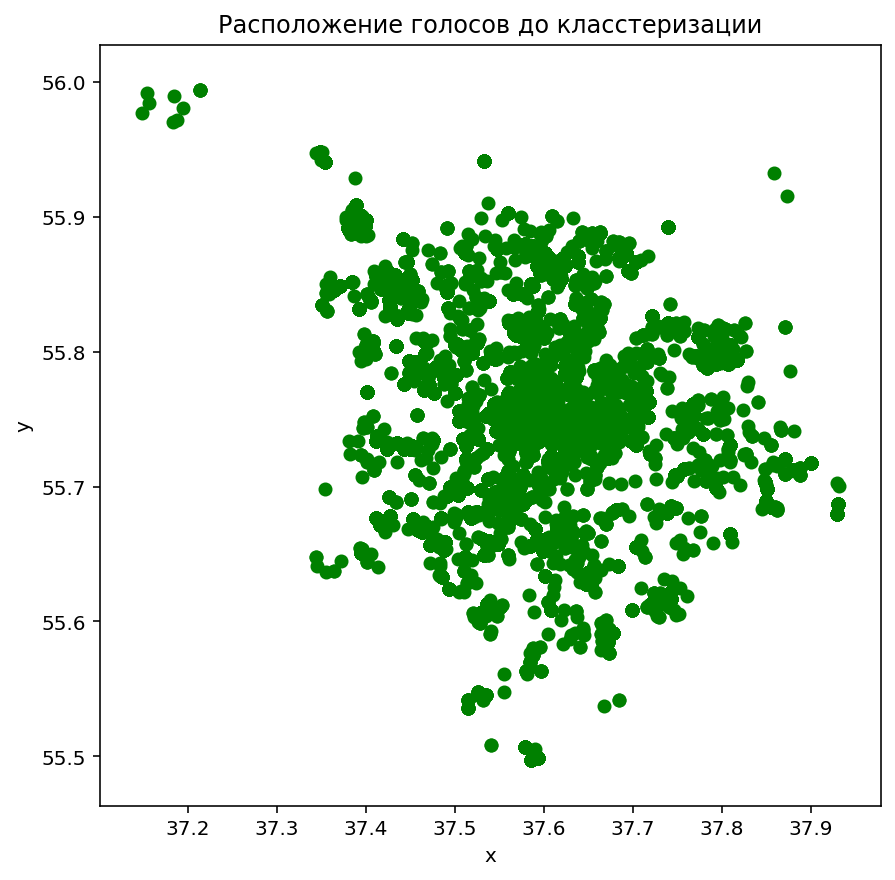

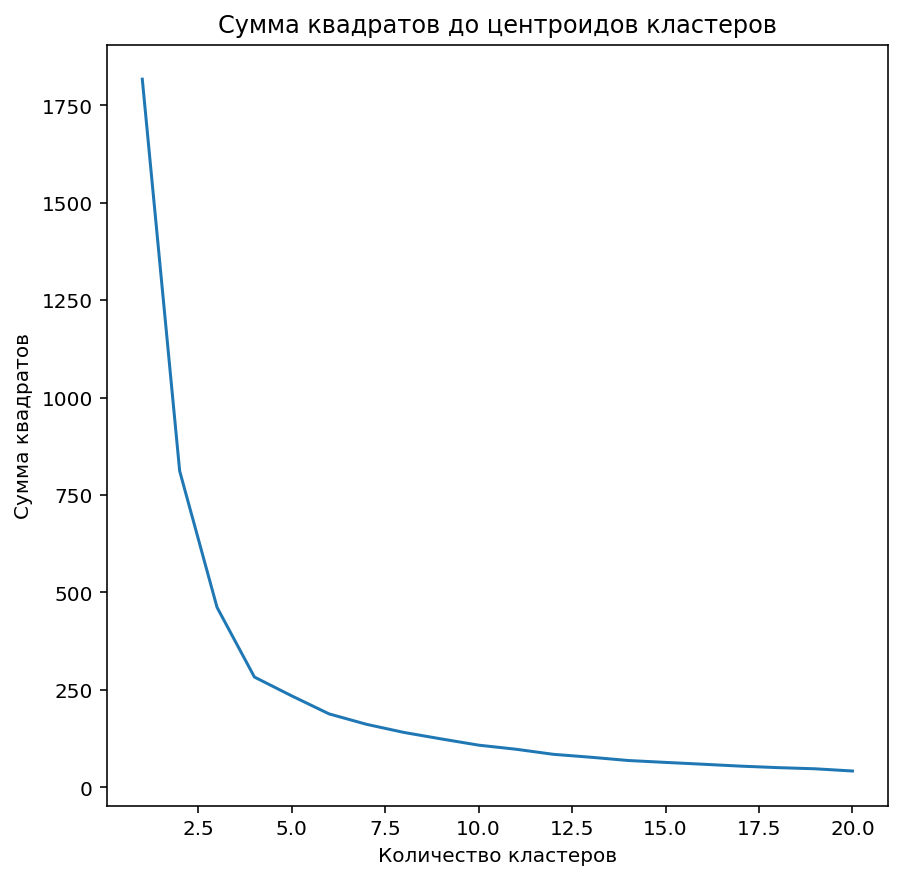

Оптимальное количество кластеров - 4


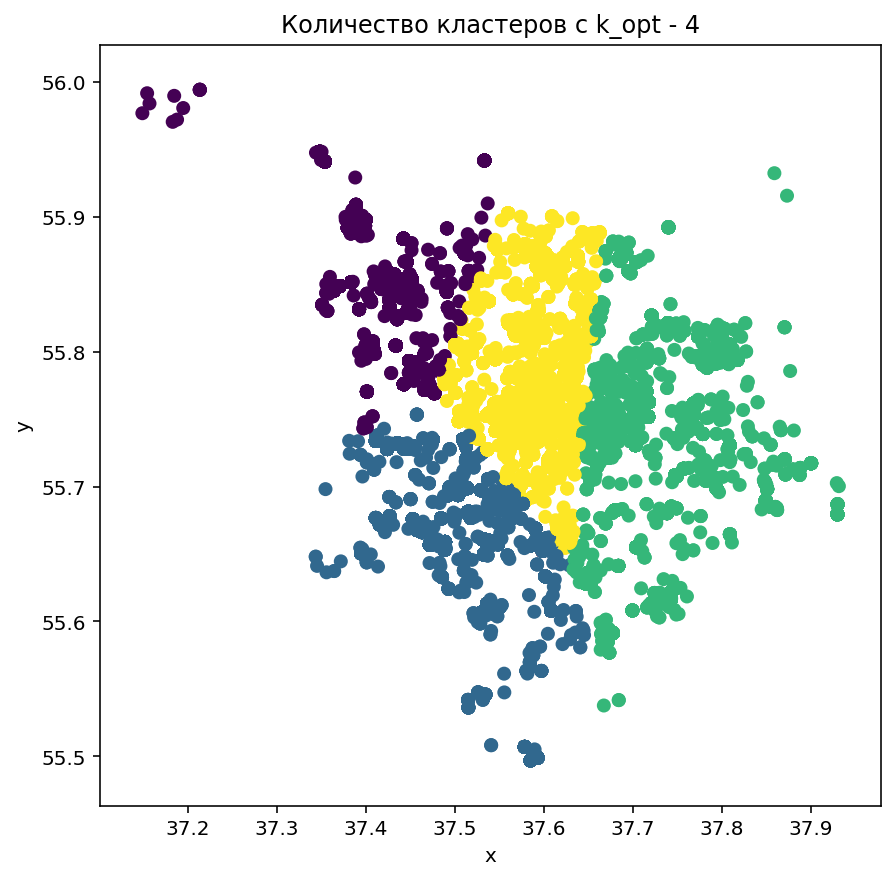

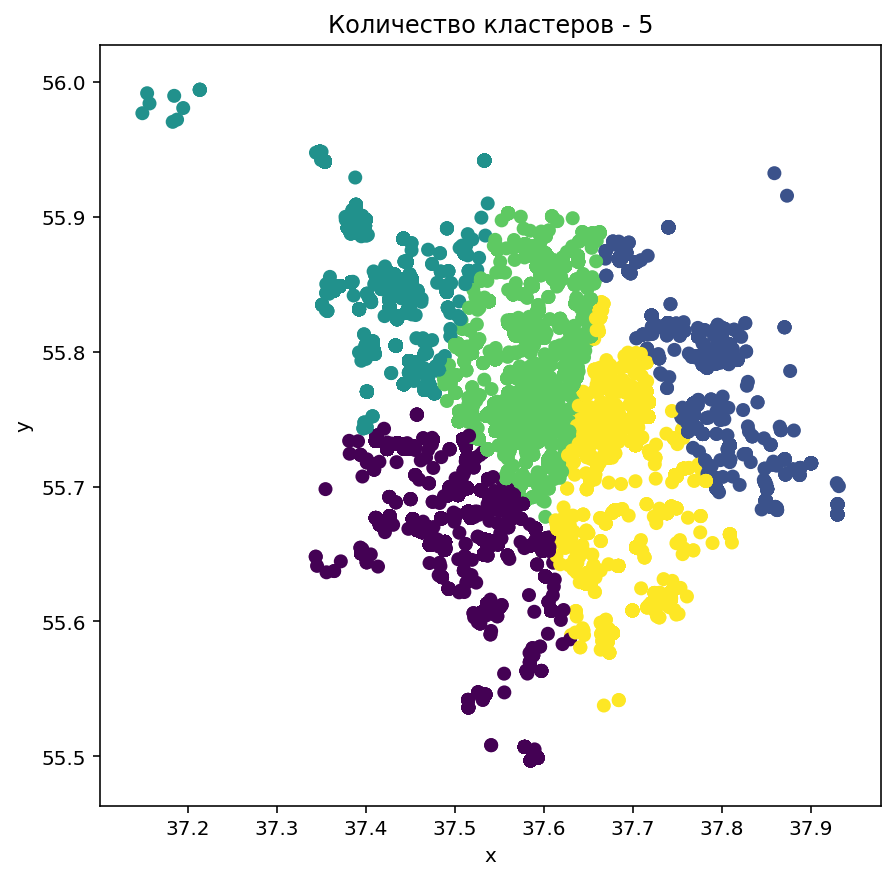

In [9]:
# С отрицательным голосом
get_clasters(data=data[data['comment_class'] == -1], n_clusters=5, clasters_range=range(1, 21))

In [10]:
# Найти наиболее активные в голосовании районы (подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')
dbscan_custers = DBSCAN(eps=0.02, min_samples=500).fit_predict(data.drop('comment_class', axis=1))
clusters_list = list(pd.value_counts(pd.DataFrame(dbscan_custers).values.flatten()).index)

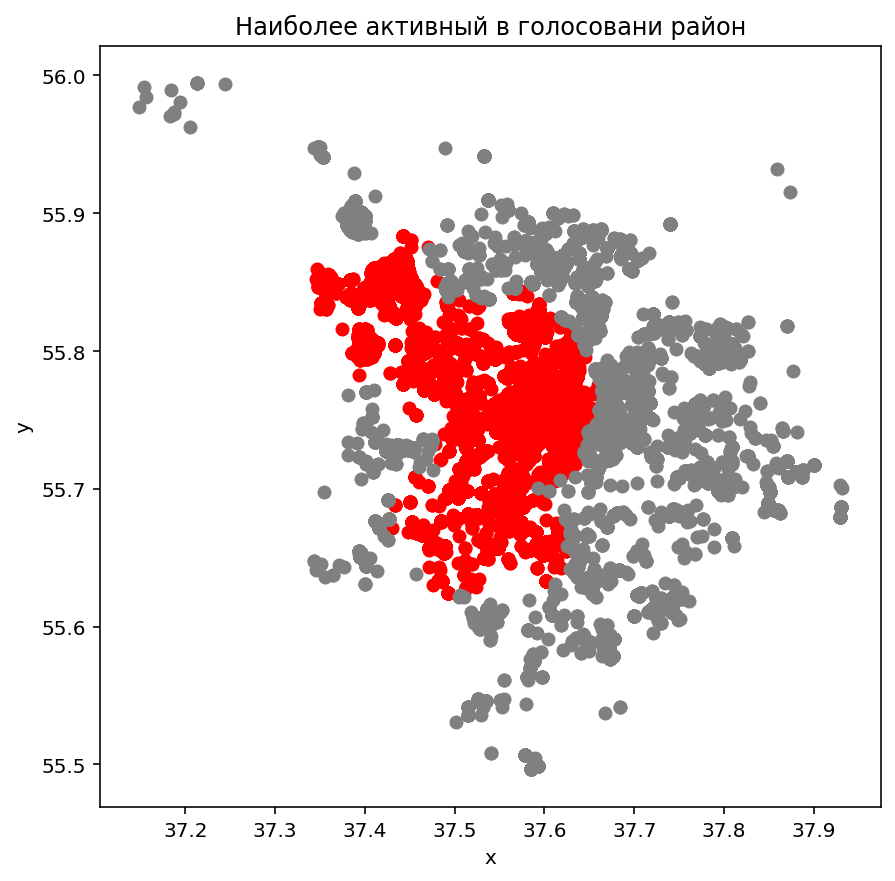

In [12]:
for i, _ in enumerate(clusters_list):
    if i == 0:
        plt.scatter(x=data.x[dbscan_custers==_], y=data.y[dbscan_custers==_], color='red')
    else:
        plt.scatter(x=data.x[dbscan_custers==_], y=data.y[dbscan_custers==_], color='grey')
plt.title('Наиболее активный в голосовани район')
plt.xlabel('x')
plt.ylabel('y')
plt.show()      